In [4]:
MODEL_ID = "llava-hf/llama3-llava-next-8b-hf"

In [5]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained(MODEL_ID)
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)
model = LlavaNextForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [12:29<00:00, 187.26s/it]


In [27]:
processor.valid_kwargs

['chat_template']

In [2]:
import datasets

ds = datasets.load_dataset("AWeirdDev/screen-qa-complex", split='train[10:20]')
#ds = ds["train"].select(range(20))
# def add_features(sample):
#     size = sample["image"].size
#     sample["image_size"] = size
#     sample["landscape"] = size[0] > size[1]
#     return sample
# num_proc=6 took 6m40s
# ds = ds.map(add_features)
ds


Dataset({
    features: ['image', 'question', 'ground_truth'],
    num_rows: 10
})

In [25]:
print(type(ds[0]["image"]))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [12]:
# prepare image and prompt for the model
i = 6

image = ds[i]["image"]
question = ds[i]["question"]
answer = ds[i]["ground_truth"]
conversation = [
    {
        "role": "system",
        "content": [
            {"type": "text", "text": "Answer as short as possible."},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": question},
        ],
    }
]
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(text=text_prompt, images=[image], return_tensors="pt").to("cuda")

for k,v in inputs.items():
    print(k,v.shape)

input_ids torch.Size([1, 34])
attention_mask torch.Size([1, 34])
pixel_values torch.Size([1, 5, 3, 336, 336])
image_sizes torch.Size([1, 2])


In [13]:
MAX_LENGTH=256
# Generate token IDs
generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)

# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [14]:
print(question)

How many more pages are there after page 10?


In [15]:
print(generated_texts[0].split("assistant\n\n\n")[-1])

The image shows a list of pages from a manga or comic book, starting from Page 1 and ending at Page 15. To calculate the number of pages after Page 10, we need to subtract Page 10 from the last page shown, which is Page 15. The number of pages after Page 10 is 5 (Page 11 to Page 15).


In [16]:
print(answer)

5


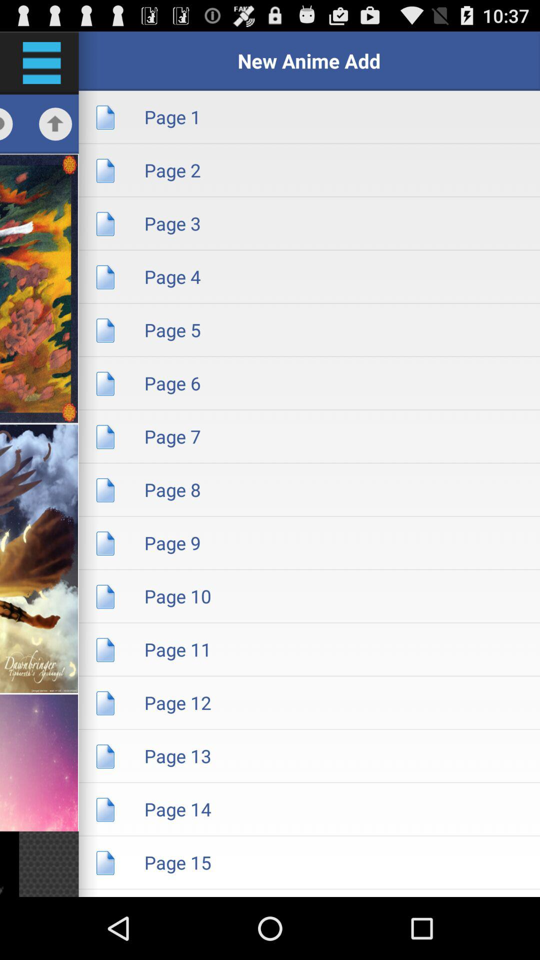

In [17]:
image.resize((int(image.size[0] * 0.5), int(image.size[1] * 0.5)))